In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import astropy.units as u
import ndcube
import sunpy.map
import astropy.wcs
from astropy.wcs.utils import wcs_to_celestial_frame, pixel_to_pixel
from astropy.visualization import ImageNormalize, LogStretch, AsymmetricPercentileInterval
import distributed
import dask.array

from synthesizAR.instruments.util import extend_celestial_wcs

from overlappy.util import color_lat_lon_axes, strided_array

from mocksipipeline.util import stack_components
from mocksipipeline.physics.spectral import SpectralModel
from mocksipipeline.detector.response import SpectrogramChannel, convolve_with_response

In [2]:
def get_norm_from_percentile(data, lower_percentile=1, upper_percentile=99, unit=None, stretch=LogStretch()):
    interval = AsymmetricPercentileInterval(lower_percentile, upper_percentile)
    if unit is None:
        unit = data.unit
    vmin,vmax = interval.get_limits(data.to_value(unit))
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch)
    return norm

# EM Distributions from Barnes et al. (2019)

In this notebook, I'm attempting to model some MOXSI observations based on some old simulations I did where I got an EM cube by inverting simulating AIA intensities that were averaged over 

In [27]:
def h5_emcube_to_ndcube(file, rebin=True, target_resolution=(7.4,7.4)*u.arcsec/u.pix):
    # Read in data
    with h5py.File(file) as hf:
        meta = dict(hf['meta'].attrs)
        em_data = u.Quantity(hf['emission_measure'][:], hf['emission_measure'].attrs['unit'])
        temperature_bin_edges = u.Quantity(hf['temperature_bin_edges'][:], hf['temperature_bin_edges'].attrs['unit'])
    
    # Calculate temperature bin centers
    log_bin_edges = np.log10(temperature_bin_edges.to_value('K'))
    log_bin_centers = (log_bin_edges[:-1] + log_bin_edges[1:])/2
    temperature_bin_centers = 10**log_bin_centers*u.K
    # Edit metadata
    for k in ['bitpix', 't_obs', 'temp_a', 'temp_b', 'temp_unit', 'tunit']:
        del meta[k]
    # Resample each slice down to a resolution closer to MOXSI
    rebinned_slices = []
    for i in range(em_data.shape[-1]):
        _m = sunpy.map.Map(em_data[...,i], meta)
        if rebin:
            superpix_size = np.floor([(target_resolution[0]/_m.scale.axis1).decompose(),
                                      (target_resolution[1]/_m.scale.axis2).decompose()])
            _m = _m.superpixel(superpix_size*u.pix, func=np.mean)
        rebinned_slices.append(_m.data)
    em_data_rebinned = u.Quantity(rebinned_slices, em_data.unit)
    rebinned_celestial_wcs = _m.wcs
    rebinned_meta = _m.meta
    # Construct NDCube
    full_wcs = extend_celestial_wcs(rebinned_celestial_wcs, temperature_bin_centers, 'temperature', 'phys.temperature')
    return ndcube.NDCube(em_data_rebinned, wcs=full_wcs, meta=rebinned_meta, )

In [28]:
em_hf = h5_emcube_to_ndcube('data/barnes_2019_em_cubes/em_cube_high_frequency.h5', rebin=True)

In [29]:
em_lf = h5_emcube_to_ndcube('data/barnes_2019_em_cubes/em_cube_low_frequency.h5')

In [30]:
em_hf

NDCube
------
Dimensions: [17. 43. 45.] pix
Physical Types of Axes: [('phys.temperature',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: 1 / cm5
Data Type: float64

In [31]:
t_bin_centers = em_hf.axis_world_coords(0)[0]

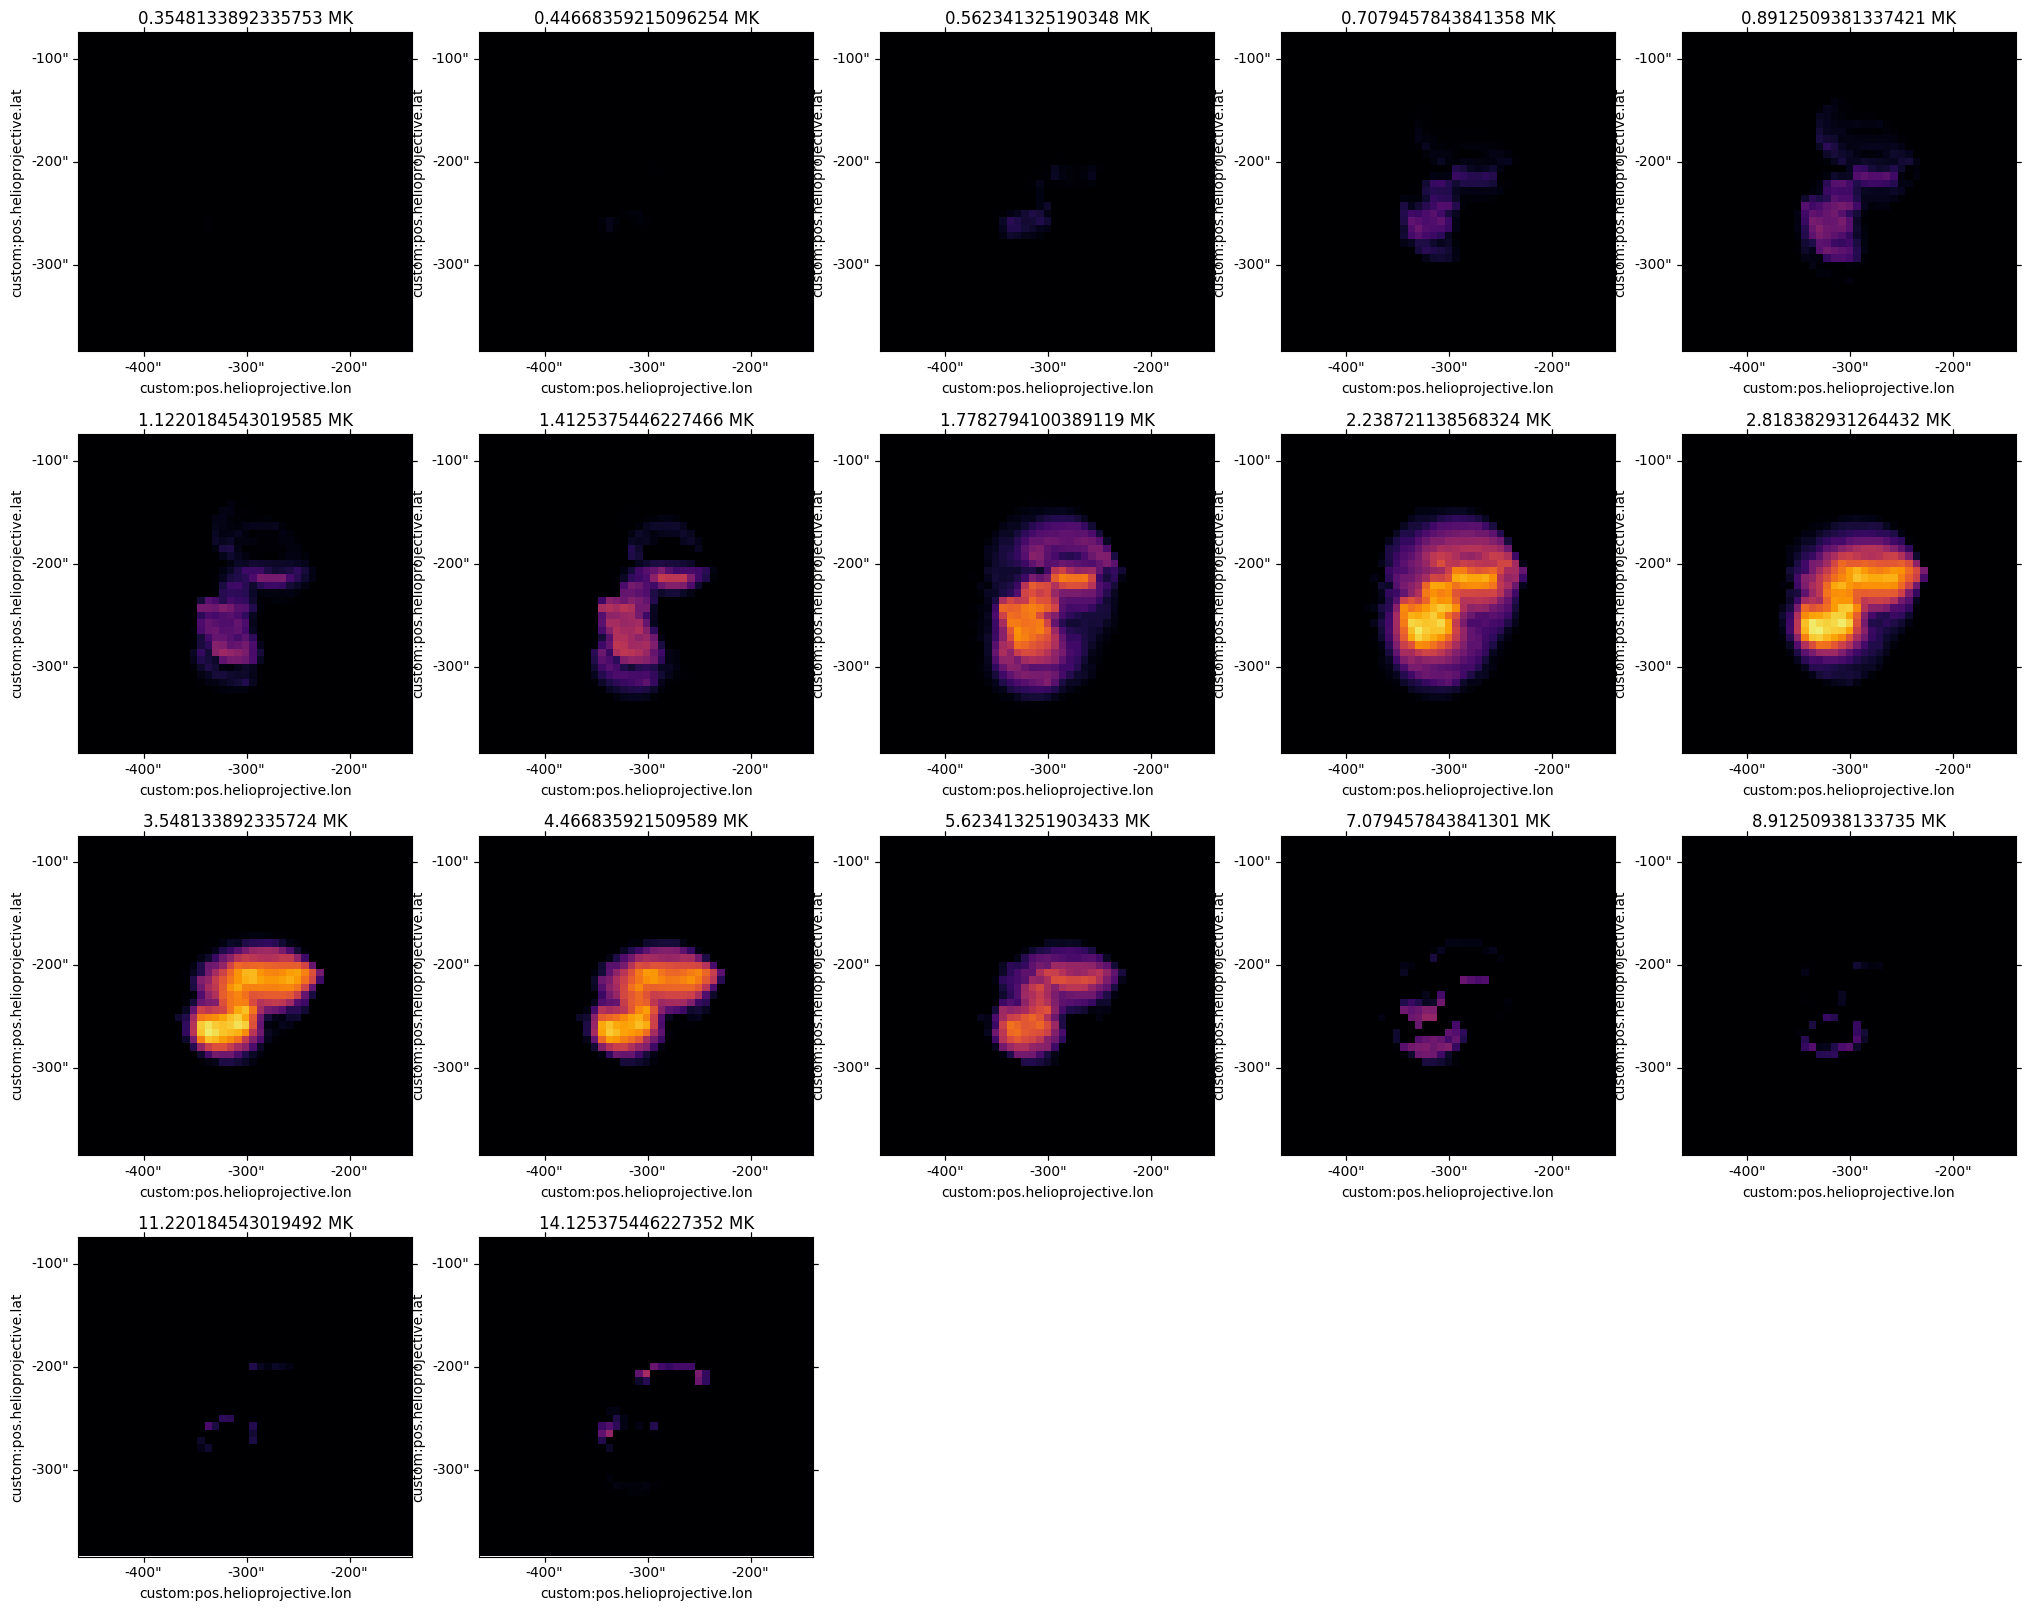

In [33]:
fig = plt.figure(figsize=(25,20))
for i,c in enumerate(em_hf):
    ax = fig.add_subplot(4,5,i+1,projection=c.wcs)
    c.plot(axes=ax, norm=ImageNormalize(vmin=1e24, vmax=5e27, stretch=LogStretch()), cmap='inferno')
    ax.set_title(t_bin_centers[i].to('MK'))

## Spectral Cube

In [34]:
spec_model = SpectralModel(spectral_table='sun_coronal_1992_feldman_ext_all')

In [35]:
spec_cube_hf = spec_model.run(em_hf, astropy.wcs.WCS(header=em_hf.meta))
spec_cube_lf = spec_model.run(em_lf, astropy.wcs.WCS(header=em_lf.meta))

## Sample photons from Poisson distribution

In [8]:
client = distributed.Client(address='tcp://127.0.0.1:52002')

In [15]:
def sample_spectral_cube(spec_cube, order, dt=1*u.s, interval=20*u.s):
    """
    Sample a Poisson distribution based on counts from spectral cube and map counts to detector pixels.
    """
    # Convert to instrument units
    observer = wcs_to_celestial_frame(spec_cube.wcs).observer
    chan = SpectrogramChannel(order)
    instr_cube = convolve_with_response(spec_cube, chan, electrons=False)
    # Sample distribution
    lam = (instr_cube.data * instr_cube.unit * u.pix * dt).to_value('photon')
    # NOTE: this should not be needed in general...
    lam = np.where(lam<0, 0, lam)
    lam = dask.array.from_array(lam, chunks=lam.shape)
    num_iterations = int(np.ceil((interval / dt).decompose()))
    samples = dask.array.random.poisson(lam=lam, size=(num_iterations,)+lam.shape).sum(axis=0)
    idx_nonzero = dask.array.where(samples>0)
    idx_nonzero = [i.compute() for i in idx_nonzero]
    weights = samples[samples>0].compute()
    # Map counts to detector coordinates
    overlap_wcs = chan.get_wcs(observer)
    idx_nonzero_overlap = pixel_to_pixel(instr_cube.wcs, overlap_wcs, *idx_nonzero[::-1])
    n_rows = chan.detector_shape[0]//2
    n_cols = chan.detector_shape[1]
    hist, _, _ = np.histogram2d(idx_nonzero_overlap[1], idx_nonzero_overlap[0],
                                bins=(n_rows, n_cols),
                                range=([-.5, n_rows-.5], [-.5, n_cols-.5]),
                                weights=weights)
    return ndcube.NDCube(strided_array(hist, chan.wavelength.shape[0],),
                         wcs=overlap_wcs,
                         unit='photon')

In [36]:
overlappograms_hf = {
    #-3: sample_spectral_cube(spec_cube_hf, -3, interval=1*u.hour),
    #-1: sample_spectral_cube(spec_cube_hf, -1, interval=1*u.hour),
    0: sample_spectral_cube(spec_cube_hf, 0, interval=1*u.hour),
    1: sample_spectral_cube(spec_cube_hf, 1, interval=1*u.hour),
    2: sample_spectral_cube(spec_cube_hf, 2, interval=1*u.hour),
    3: sample_spectral_cube(spec_cube_hf, 3, interval=1*u.hour),
    4: sample_spectral_cube(spec_cube_hf, 4, interval=1*u.hour),
}

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result =

In [37]:
total_overlappogram_hf = stack_components([v for k,v in overlappograms_hf.items()], wcs_index=2)

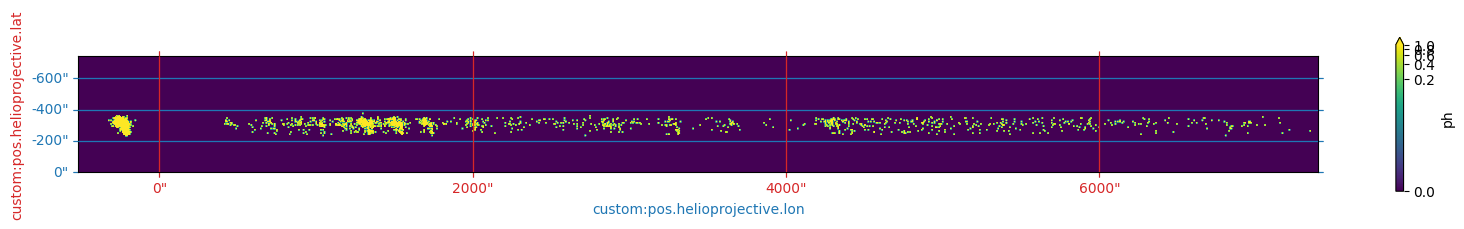

In [38]:
data_unit = u.Unit('photon')

fig = plt.figure(figsize=(20,2))
cropped_cube = total_overlappogram_hf[0,375:475,930:]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.5, lower_percentile=1, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

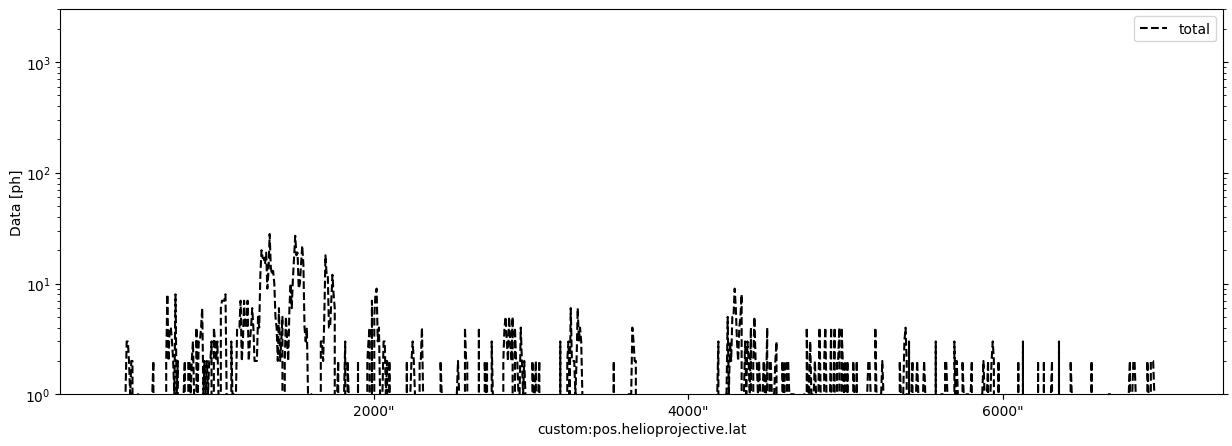

2023-06-17 15:46:23,253 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [40]:
data_unit = 'ph'
fig = plt.figure(figsize=(15,5))
total_rebin = total_overlappogram_hf[0].rebin((total_overlappogram_hf[0].data.shape[0], 1),operation=np.sum)[0]
ax = fig.add_subplot(projection=total_rebin)
#for order,component in overlappograms_hf.items():
#    component[0].rebin((component[0].data.shape[0], 1),operation=np.sum)[0].plot(axes=ax, label=f'order={order}', data_unit=data_unit)
total_rebin.plot(axes=ax, color='k', ls='--', label='total', data_unit=data_unit)
#ax.axhline(y=1, color='k', ls=':')
ax.set_yscale('log')
ax.set_ylim(1, 3000)
ax.set_xlim(1000,2000)
ax.legend(ncol=3)

In [36]:
overlappograms_lf = {
    -3: sample_spectral_cube(spec_cube_lf, -3, interval=1*u.hour),
    -1: sample_spectral_cube(spec_cube_lf, -1, interval=1*u.hour),
    0: sample_spectral_cube(spec_cube_lf, 0, interval=1*u.hour),
    1: sample_spectral_cube(spec_cube_lf, 1, interval=1*u.hour),
    3: sample_spectral_cube(spec_cube_lf, 3, interval=1*u.hour)
}

/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  'angstrom' -> 'Angstrom'. [astropy.wcs.wcs]
/Users/wtbarnes/mambaforge/envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result =

In [37]:
total_overlappogram_lf = stack_components([v for k,v in overlappograms_lf.items()], wcs_index=2)

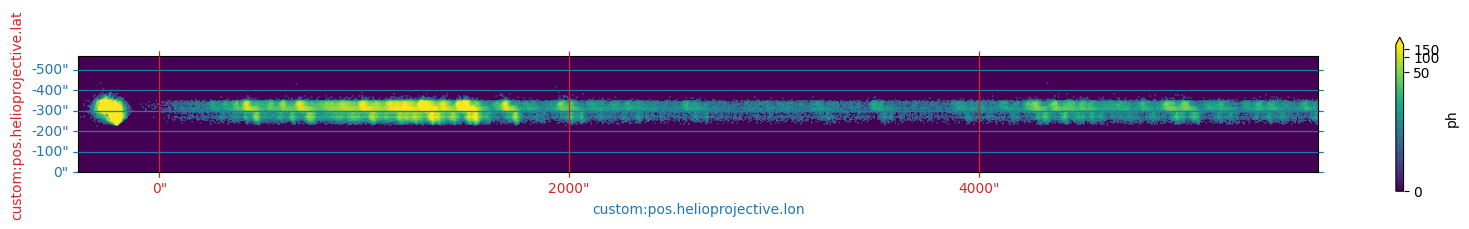

In [39]:
data_unit = u.Unit('photon')

fig = plt.figure(figsize=(20,2))
cropped_cube = total_overlappogram_lf[0,375:475,930:]#[0,375:475,930:1500]

ax = fig.add_subplot(111, projection=cropped_cube.wcs)
cropped_cube.plot(
    axes=ax,
    norm=get_norm_from_percentile(cropped_cube.data*cropped_cube.unit, upper_percentile=99.5, lower_percentile=1, unit=data_unit),
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')
cb = fig.colorbar(ax.get_images()[0], extend='max')
cb.set_label(data_unit)

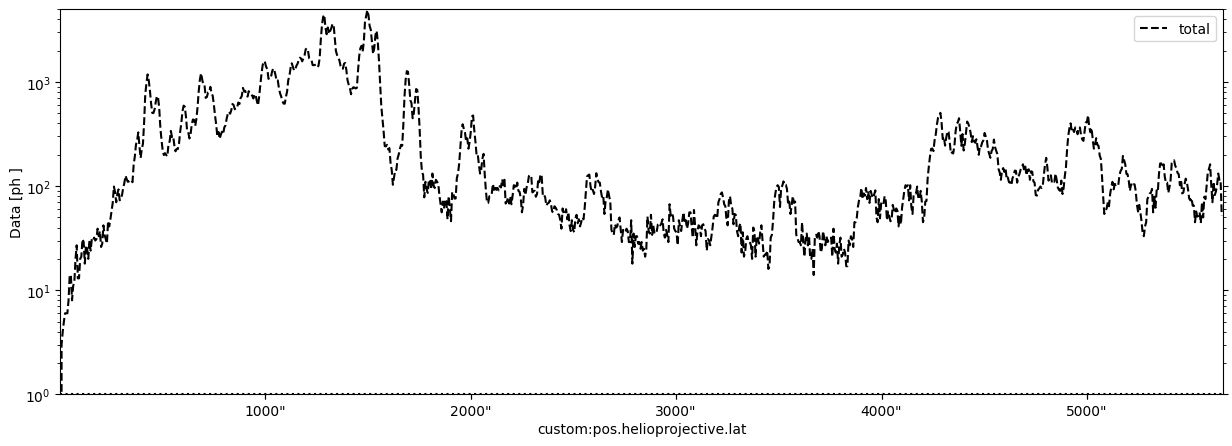

In [43]:
data_unit = 'ph '
fig = plt.figure(figsize=(15,5))
total_rebin = total_overlappogram_lf[0].rebin((total_overlappogram_lf[0].data.shape[0], 1),operation=np.sum)[0]
ax = fig.add_subplot(projection=total_rebin)
#for order,component in overlappograms_lf.items():
#    component[0].rebin((component[0].data.shape[0], 1),operation=np.sum)[0].plot(axes=ax, label=f'order={order}', data_unit=data_unit)
total_rebin.plot(axes=ax, color='k', ls='--', label='total', data_unit=data_unit)
ax.axhline(y=1, color='k', ls=':')
ax.set_yscale('log')
ax.set_ylim(1, 5000)
ax.set_xlim(1000,2000)
ax.legend(ncol=3)

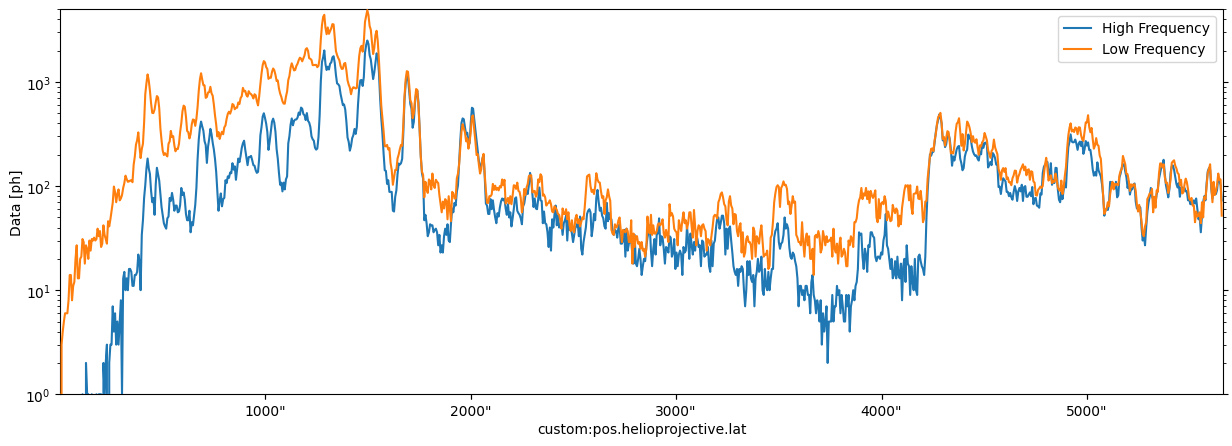

In [44]:
data_unit = 'ph'
fig = plt.figure(figsize=(15,5))
total_rebin_hf = total_overlappogram_hf[0].rebin((total_overlappogram_hf[0].data.shape[0], 1),operation=np.sum)[0]
total_rebin_lf = total_overlappogram_lf[0].rebin((total_overlappogram_lf[0].data.shape[0], 1),operation=np.sum)[0]
ax = fig.add_subplot(projection=total_rebin_hf)
total_rebin_hf.plot(axes=ax, label='High Frequency', data_unit=data_unit)
total_rebin_lf.plot(axes=ax, label='Low Frequency', data_unit=data_unit)
ax.set_yscale('log')
ax.set_ylim(1, 5e3)
ax.set_xlim(1000,2000)
ax.legend()

In [45]:
intensity_ratio = total_rebin_lf.data / total_rebin_hf.data

/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_52562/1177835263.py:1: RuntimeWarning: divide by zero encountered in divide
  intensity_ratio = total_rebin_lf.data / total_rebin_hf.data
/var/folders/cr/pj7yk8p976d7ny98bgvlpfyr0000gq/T/ipykernel_52562/1177835263.py:1: RuntimeWarning: invalid value encountered in divide
  intensity_ratio = total_rebin_lf.data / total_rebin_hf.data


(930.0, 2000.0)

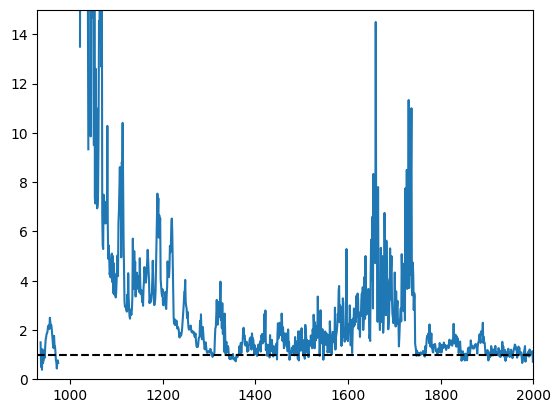

In [46]:
plt.plot(intensity_ratio)
plt.ylim(0,15)
plt.axhline(y=1, ls='--', color='k')
plt.xlim(930,2000)

In [63]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

(<astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x34029fca0>,
 <astropy.visualization.wcsaxes.coordinate_helpers.CoordinateHelper at 0x340c0cdf0>)

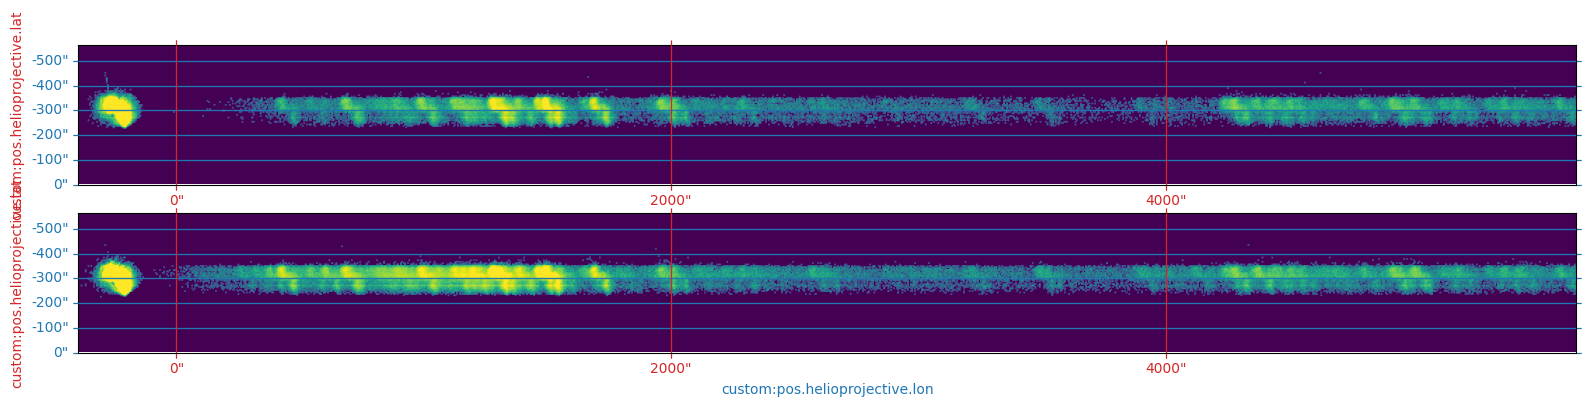

In [68]:
data_unit = u.Unit('photon')

fig = plt.figure(figsize=(20,4))
sl = np.s_[0,375:475,930:]
cropped_cube_hf = total_overlappogram_hf[sl]
cropped_cube_lf = total_overlappogram_lf[sl]

norm = get_norm_from_percentile(cropped_cube_lf.data*cropped_cube_lf.unit, upper_percentile=99.5, lower_percentile=1, unit=data_unit)

ax = fig.add_subplot(211, projection=cropped_cube_hf.wcs)
cropped_cube_hf.plot(
    axes=ax,
    norm=norm,
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
#cax = make_axes_locatable(ax).append_axes("top", size="8%", pad="2%", axes_class=matplotlib.axes.Axes)
#cb = fig.colorbar(ax.get_images()[0], cax=cax, orientation='horizontal')
#cax.xaxis.set_ticks_position("top")
ax = fig.add_subplot(212, projection=cropped_cube_lf.wcs,)
cropped_cube_lf.plot(
    axes=ax,
    norm=norm,
    data_unit=data_unit,
    cmap='viridis',
)
color_lat_lon_axes(ax)
#ax.plot_coord(ar_slice, color='C2', ls='--')


In [ ]:
em_hf